In [1]:
#uncomment this if you are not using puffer
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

#my container always require reinstalling these dependencies; uncomment this if you don't need to
!pip install -U spacy
!pip install torchtext
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are using ", device)

import numpy as np
import spacy

import random
import math
import time

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We are using  cuda
     |████████████████████████████████| 13.9 MB 12.2 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     |████████████████████████████████| 19.1 MB 12.2 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


# 1 - TorchText + LSTM + Greedy Decoding

In this first notebook, we'll start simple to understand the general seq2seq concepts by implementing the model from the [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215) paper. This will be done on German to English translations, but the models can be applied to any problem that involves going from one sequence to another, such as summarization.

This is edited from https://github.com/bentrevett.

Note:  In this series of tutorials, I am too lazy to put `batch_size` as first dimension (i.e., `batch_first=True`, thus the shape of sentence will be `(seq len, batch size)` instead of `(batch size, seq len)`.  If you want to see how `batch_first` works, look at the `classification` folder.

### Introduction

The most common sequence-to-sequence (seq2seq) models are *encoder-decoder* models, which commonly use a *recurrent neural network* (RNN) to *encode* the source (input) sentence into a single vector. In this notebook, we'll refer to this single vector as a *context vector*. We can think of the context vector as being an abstract representation of the entire input sentence. This vector is then *decoded* by a second RNN which learns to output the target (output) sentence by generating it one word at a time.

![](assets/seq2seq1.png)

The above image shows an example translation. The input/source sentence, "guten morgen", is passed through the embedding layer (yellow) and then input into the encoder (green). We also append a *start of sequence* (`<sos>`) and *end of sequence* (`<eos>`) token to the start and end of sentence, respectively. At each time-step, the input to the encoder RNN is both the embedding, $e$, of the current word, $e(x_t)$, as well as the hidden state from the previous time-step, $h_{t-1}$, and the encoder RNN outputs a new hidden state $h_t$. We can think of the hidden state as a vector representation of the sentence so far. The RNN can be represented as a function of both of $e(x_t)$ and $h_{t-1}$:

$$h_t = \text{EncoderRNN}(e(x_t), h_{t-1})$$

We're using the term RNN generally here, it could be any recurrent architecture, such as an *LSTM* (Long Short-Term Memory) or a *GRU* (Gated Recurrent Unit). 

Here, we have $X = \{x_1, x_2, ..., x_T\}$, where $x_1 = \text{<sos>}, x_2 = \text{guten}$, etc. The initial hidden state, $h_0$, is usually either initialized to zeros or a learned parameter.

Once the final word, $x_T$, has been passed into the RNN via the embedding layer, we use the final hidden state, $h_T$, as the context vector, i.e. $h_T = z$. This is a vector representation of the entire source sentence.

Now we have our context vector, $z$, we can start decoding it to get the output/target sentence, "good morning". Again, we append start and end of sequence tokens to the target sentence. At each time-step, the input to the decoder RNN (blue) is the embedding, $d$, of current word, $d(y_t)$, as well as the hidden state from the previous time-step, $s_{t-1}$, where the initial decoder hidden state, $s_0$, is the context vector, $s_0 = z = h_T$, i.e. the initial decoder hidden state is the final encoder hidden state. Thus, similar to the encoder, we can represent the decoder as:

$$s_t = \text{DecoderRNN}(d(y_t), s_{t-1})$$

Although the input/source embedding layer, $e$, and the output/target embedding layer, $d$, are both shown in yellow in the diagram they are two different embedding layers with their own parameters.

In the decoder, we need to go from the hidden state to an actual word, therefore at each time-step we use $s_t$ to predict (by passing it through a `Linear` layer, shown in purple) what we think is the next word in the sequence, $\hat{y}_t$. 

$$\hat{y}_t = f(s_t)$$

The words in the decoder are always generated one after another, with one per time-step. We always use `<sos>` for the first input to the decoder, $y_1$, but for subsequent inputs, $y_{t>1}$, we will sometimes use the actual, ground truth next word in the sequence, $y_t$ and sometimes use the word predicted by our decoder, $\hat{y}_{t-1}$. This is called **teacher forcing**. 

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference it is common to keep generating words until the model outputs an `<eos>` token or after a certain amount of words have been generated.

Once we have our predicted target sentence, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, we compare it against our actual target sentence, $Y = \{ y_1, y_2, ..., y_T \}$, to calculate our loss. We then use this loss to update all of the parameters in our model.

## 1. Preprocessing

### Load the dataset

In [2]:
from torchtext.datasets import Multi30k

SRC_LANGUAGE = 'de'
TRG_LANGUAGE = 'en'
train_iter, valid_iter, test_iter = Multi30k(split=('train', 'valid', 'test'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

In [3]:
len(train_iter)

29000

In [4]:
#let's try print one train sample
#a pair of src sentence (de) and target sentence (en)
sample = next(train_iter)
sample

('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.\n',
 'Two young, White males are outside near many bushes.\n')

### Tokenizers

**Note**: the models must first be downloaded using the following on the command line: 
```
python -m spacy download en_core_web_sm
python -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [5]:
# Place-holders
token_transform = {}
vocab_transform = {}

Here is our two tokenizers:

In [6]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [7]:
#example of tokenization of the english part
print("English sentence: ", sample[1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[1]))

English sentence:  Two young, White males are outside near many bushes.

Tokenization:  ['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '\n']


A function to tokenize our input.  That is, the first index of the input will apply the SRC_LANGUAGE tokenizer, and the second index input will apply the TRG_LANGUAGE tokenizer.

In [8]:
# helper function to yield list of tokens
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [9]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [10]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [11]:
#see some example
vocab_transform[TRG_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[2208, 11, 4, 0, 4]

In [12]:
len(vocab_transform[TRG_LANGUAGE])

10838

### Batch Iterator

The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have our X (the PyTorch tensors containing a batch of numericalized source sentences) and Y (the PyTorch tensors containing a batch of numericalized target sentences). Numericalized is just a fancy way of saying they have been converted from a sequence of readable tokens to a sequence of corresponding indexes, using the vocabulary. 

When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. We will use the function <code>pad_sequence</code>

In [13]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, trg_batch


In [14]:
from torchtext.data.functional import to_map_style_dataset

train_iter, valid_iter, test_iter = Multi30k(split=('train', 'valid', 'test'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

#if we simply use train_iter, once we run it, it cannot be iterate more, so let's convert to map style dataset
train_dataset = to_map_style_dataset(train_iter)
valid_dataset = to_map_style_dataset(valid_iter)
test_dataset = to_map_style_dataset(test_iter)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_fn)

In [15]:
src, trg = next(iter(train_loader))
print("src shape: ", src.shape) # (seq len, batch_size)
print("trg shape: ", trg.shape) # (seq len, batch_size)  #if you like batch size first, simply set batch_first = True

src shape:  torch.Size([25, 64])
trg shape:  torch.Size([26, 64])


## 2. Building the Seq2Seq Model

We'll be building our model in three parts. The encoder, the decoder and a seq2seq model that encapsulates the encoder and decoder and will provide a way to interface with each.

### Encoder

First, the encoder, a 2 layer LSTM. The paper we are implementing uses a 4-layer LSTM, but in the interest of training time we cut this down to 2-layers. The concept of multi-layer RNNs is easy to expand from 2 to 4 layers. 

For a multi-layer RNN, the input sentence, $X$, after being embedded goes into the first (bottom) layer of the RNN and hidden states, $H=\{h_1, h_2, ..., h_T\}$, output by this layer are used as inputs to the RNN in the layer above. Thus, representing each layer with a superscript, the hidden states in the first layer are given by:

$$h_t^1 = \text{EncoderRNN}^1(e(x_t), h_{t-1}^1)$$

The hidden states in the second layer are given by:

$$h_t^2 = \text{EncoderRNN}^2(h_t^1, h_{t-1}^2)$$

Using a multi-layer RNN also means we'll also need an initial hidden state as input per layer, $h_0^l$, and we will also output a context vector per layer, $z^l$.

Without going into too much detail about LSTMs, all we need to know is that they're a type of RNN which instead of just taking in a hidden state and returning a new hidden state per time-step, also take in and return a *cell state*, $c_t$, per time-step.

$$\begin{align*}
h_t &= \text{RNN}(e(x_t), h_{t-1})\\
(h_t, c_t) &= \text{LSTM}(e(x_t), h_{t-1}, c_{t-1})
\end{align*}$$

We can just think of $c_t$ as another type of hidden state. Similar to $h_0^l$, $c_0^l$ will be initialized to a tensor of all zeros. Also, our context vector will now be both the final hidden state and the final cell state, i.e. $z^l = (h_T^l, c_T^l)$.

Extending our multi-layer equations to LSTMs, we get:

$$\begin{align*}
(h_t^1, c_t^1) &= \text{EncoderLSTM}^1(e(x_t), (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) &= \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}$$

Note how only our hidden state from the first layer is passed as input to the second layer, and not the cell state.

So our encoder looks something like this: 

![](assets/seq2seq2.png)

We create this in code by making an `Encoder` module, which requires we inherit from `torch.nn.Module` and use the `super().__init__()` as some boilerplate code. The encoder takes the following arguments:
- `input_dim` is the size/dimensionality of the one-hot vectors that will be input to the encoder. This is equal to the input (source) vocabulary size.
- `emb_dim` is the dimensionality of the embedding layer. This layer converts the one-hot vectors into dense vectors with `emb_dim` dimensions. 
- `hid_dim` is the dimensionality of the hidden and cell states.
- `n_layers` is the number of layers in the RNN.
- `dropout` is the amount of dropout to use. This is a regularization parameter to prevent overfitting. Check out [this](https://www.coursera.org/lecture/deep-neural-network/understanding-dropout-YaGbR) for more details about dropout.

The embedding layer is created using `nn.Embedding`, the LSTM with `nn.LSTM` and a dropout layer with `nn.Dropout`. Check the PyTorch [documentation](https://pytorch.org/docs/stable/nn.html) for more about these.

One thing to note is that the `dropout` argument to the LSTM is how much dropout to apply between the layers of a multi-layer RNN, i.e. between the hidden states output from layer $l$ and those same hidden states being used for the input of layer $l+1$.

In the `forward` method, we pass in the source sentence, $X$, which is converted into dense vectors using the `embedding` layer, and then dropout is applied. These embeddings are then passed into the RNN. As we pass a whole sequence to the RNN, it will automatically do the recurrent calculation of the hidden states over the whole sequence for us! Notice that we do not pass an initial hidden or cell state to the RNN. This is because, as noted in the [documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM), that if no hidden/cell state is passed to the RNN, it will automatically create an initial hidden/cell state as a tensor of all zeros. 

The RNN returns: `outputs` (the top-layer hidden state for each time-step), `hidden` (the final hidden state for each layer, $h_T$, stacked on top of each other) and `cell` (the final cell state for each layer, $c_T$, stacked on top of each other).

As we only need the final hidden and cell states (to make our context vector), `forward` only returns `hidden` and `cell`. 

The sizes of each of the tensors is left as comments in the code. In this implementation `n_directions` will always be 1, however note that bidirectional RNNs (covered later) will have `n_directions` as 2.

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [seq len, batch size]
        embedded = self.dropout(self.embedding(src))
        #embedded = [seq len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        #outputs = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

### Decoder

Next, we'll build our decoder, which will also be a 2-layer (4 in the paper) LSTM.

![](assets/seq2seq3.png)

The `Decoder` class does a single step of decoding, i.e. it ouputs single token per time-step. The first layer will receive a hidden and cell state from the previous time-step, $(s_{t-1}^1, c_{t-1}^1)$, and feeds it through the LSTM with the current embedded token, $y_t$, to produce a new hidden and cell state, $(s_t^1, c_t^1)$. The subsequent layers will use the hidden state from the layer below, $s_t^{l-1}$, and the previous hidden and cell states from their layer, $(s_{t-1}^l, c_{t-1}^l)$. This provides equations very similar to those in the encoder.

$$\begin{align*}
(s_t^1, c_t^1) = \text{DecoderLSTM}^1(d(y_t), (s_{t-1}^1, c_{t-1}^1))\\
(s_t^2, c_t^2) = \text{DecoderLSTM}^2(s_t^1, (s_{t-1}^2, c_{t-1}^2))
\end{align*}$$

Remember that the initial hidden and cell states to our decoder are our context vectors, which are the final hidden and cell states of our encoder from the same layer, i.e. $(s_0^l,c_0^l)=z^l=(h_T^l,c_T^l)$.

We then pass the hidden state from the top layer of the RNN, $s_t^L$, through a linear layer, $f$, to make a prediction of what the next token in the target (output) sequence should be, $\hat{y}_{t+1}$. 

$$\hat{y}_{t+1} = f(s_t^L)$$

The arguments and initialization are similar to the `Encoder` class, except we now have an `output_dim` which is the size of the vocabulary for the output/target. There is also the addition of the `Linear` layer, used to make the predictions from the top layer hidden state.

Within the `forward` method, we accept a batch of input tokens, previous hidden states and previous cell states. As we are only decoding one token at a time, the input tokens will always have a sequence length of 1. We `unsqueeze` the input tokens to add a sentence length dimension of 1. Then, similar to the encoder, we pass through an embedding layer and apply dropout. This batch of embedded tokens is then passed into the RNN with the previous hidden and cell states. This produces an `output` (hidden state from the top layer of the RNN), a new `hidden` state (one for each layer, stacked on top of each other) and a new `cell` state (also one per layer, stacked on top of each other). We then pass the `output` (after getting rid of the sentence length dimension) through the linear layer to receive our `prediction`. We then return the `prediction`, the new `hidden` state and the new `cell` state.

**Note**: as we always have a sequence length of 1, we could use `nn.LSTMCell`, instead of `nn.LSTM`, as it is designed to handle a batch of inputs that aren't necessarily in a sequence. `nn.LSTMCell` is just a single cell and `nn.LSTM` is a wrapper around potentially multiple cells. Using the `nn.LSTMCell` in this case would mean we don't have to `unsqueeze` to add a fake sequence length dimension, but we would need one `nn.LSTMCell` per layer in the decoder and to ensure each `nn.LSTMCell` receives the correct initial hidden state from the encoder. All of this makes the code less concise - hence the decision to stick with the regular `nn.LSTM`.

In [17]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

### Seq2Seq

For the final part of the implemenetation, we'll implement the seq2seq model. This will handle: 
- receiving the input/source sentence
- using the encoder to produce the context vectors 
- using the decoder to produce the predicted output/target sentence

Our full model will look like this:

![](assets/seq2seq4.png)

The `Seq2Seq` model takes in an `Encoder`, `Decoder`, and a `device` (used to place tensors on the GPU, if it exists).

For this implementation, we have to ensure that the number of layers and the hidden (and cell) dimensions are equal in the `Encoder` and `Decoder`. This is not always the case, we do not necessarily need the same number of layers or the same hidden dimension sizes in a sequence-to-sequence model. However, if we did something like having a different number of layers then we would need to make decisions about how this is handled. For example, if our encoder has 2 layers and our decoder only has 1, how is this handled? Do we average the two context vectors output by the decoder? Do we pass both through a linear layer? Do we only use the context vector from the highest layer? Etc.

Our `forward` method takes the source sentence, target sentence and a teacher-forcing ratio. The teacher forcing ratio is used when training our model. When decoding, at each time-step we will predict what the next token in the target sequence will be from the previous tokens decoded, $\hat{y}_{t+1}=f(s_t^L)$. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth next token in the sequence as the input to the decoder during the next time-step. However, with probability `1 - teacher_forcing_ratio`, we will use the token that the model predicted as the next input to the model, even if it doesn't match the actual next token in the sequence.  

The first thing we do in the `forward` method is to create an `outputs` tensor that will store all of our predictions, $\hat{Y}$.

We then feed the input/source sentence, `src`, into the encoder and receive out final hidden and cell states.

The first input to the decoder is the start of sequence (`<sos>`) token. As our `trg` tensor already has the `<sos>` token appended, we get our $y_1$ by slicing into it. We know how long our target sentences should be (`max_len`), so we loop that many times. The last token input into the decoder is the one **before** the `<eos>` token - the `<eos>` token is never input into the decoder. 

During each iteration of the loop, we:
- pass the input, previous hidden and previous cell states ($y_t, s_{t-1}, c_{t-1}$) into the decoder
- receive a prediction, next hidden state and next cell state ($\hat{y}_{t+1}, s_{t}, c_{t}$) from the decoder
- place our prediction, $\hat{y}_{t+1}$ (`output`) in our tensor of predictions, $\hat{Y}$ (`outputs`)
- decide if we are going to "teacher force" or not
    - if we do, the next `input` is the ground-truth next token in the sequence, $y_{t+1}$ (`trg[t]`)
    - if we don't, the next `input` is the predicted next token in the sequence, $\hat{y}_{t+1}$ (`top1`), which we get by doing an `argmax` over the output tensor, i.e., greedy decoding
    
Once we've made all of our predictions, we return our tensor full of predictions, $\hat{Y}$ (`outputs`).

**Note**: our decoder loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

Later on when we calculate the loss, we cut off the first element of each tensor to get:

$$\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

In [18]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_output_dim = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_output_dim).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input_ = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input_, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

## 3. Training the Seq2Seq Model

Now we have our model implemented, we can begin training it. 

First, we'll initialize our model. As mentioned before, the input and output dimensions are defined by the size of the vocabulary. The embedding dimesions and dropout for the encoder and decoder can be different, but the number of layers and the size of the hidden/cell states must be the same. 

We then define the encoder, decoder and then our Seq2Seq model, which we place on the `device`.

In [19]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
ENC_EMB_DIM = 256  #follow the paper
DEC_EMB_DIM = 256  #follow the paper
HID_DIM = 512  #follow the paper
N_LAYERS = 2   #the papers use 4
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

Next up is initializing the weights of our model. In the paper they state they initialize all weights from a uniform distribution between -0.08 and +0.08, i.e. $\mathcal{U}(-0.08, 0.08)$.

We initialize weights in PyTorch by creating a function which we `apply` to our model. When using `apply`, the `init_weights` function will be called on every module and sub-module within our model. For each module we loop through all of the parameters and sample them from a uniform distribution with `nn.init.uniform_`.

In [20]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(19215, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10838, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=10838, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

We also define a function that will calculate the number of trainable parameters in the model.

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,609,878 trainable parameters


We define our optimizer, which we use to update our parameters in the training loop. Check out [this](http://ruder.io/optimizing-gradient-descent/) post for information about different optimizers. Here, we'll use Adam.

In [22]:
optimizer = optim.Adam(model.parameters())

Next, we define our loss function. The `CrossEntropyLoss` function calculates both the log softmax as well as the negative log-likelihood of our predictions. 

Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [23]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

Next, we'll define our training loop. 

First, we'll set the model into "training mode" with `model.train()`. This will turn on dropout (and batch normalization, which we aren't using) and then iterate through our data iterator.

As stated before, our decoder loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

Here, when we calculate the loss, we cut off the first element of each tensor to get:

$$\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

At each iteration:
- get the source and target sentences from the batch, $X$ and $Y$
- zero the gradients calculated from the last batch
- feed the source and target into the model to get the output, $\hat{Y}$
- as the loss function only works on 2d inputs with 1d targets we need to flatten each of them with `.view`
    - we slice off the first column of the output and target tensors as mentioned above
- calculate the gradients with `loss.backward()`
- clip the gradients to prevent them from exploding (a common issue in RNNs)
- update the parameters of our model by doing an optimizer step
- sum the loss value to a running total

Finally, we return the loss that is averaged over all batches.

In [24]:
def train(model, loader, optimizer, criterion, clip):
    
    model.train()
    epoch_loss = 0
    
    for src, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(loader)

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

We must remember to set the model to evaluation mode with `model.eval()`. This will turn off dropout (and batch normalization, if used).

We use the `with torch.no_grad()` block to ensure no gradients are calculated within the block. This reduces memory consumption and speeds things up. 

The iteration loop is similar (without the parameter updates), however we must ensure we turn teacher forcing off for evaluation. This will cause the model to only use it's own predictions to make further predictions within a sentence, which mirrors how it would be used in deployment.

In [25]:
def evaluate(model, loader, criterion):
        
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(loader)

Next, we'll create a function that we'll use to tell us how long an epoch takes.

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We can finally start training our model!

At each epoch, we'll be checking if our model has achieved the best validation loss so far. If it has, we'll update our best validation loss and save the parameters of our model (called `state_dict` in PyTorch). Then, when we come to test our model, we'll use the saved parameters used to achieve the best validation loss. 

We'll be printing out both the loss and the perplexity at each epoch. It is easier to see a change in perplexity than a change in loss as the numbers are much bigger.

In [27]:
N_EPOCHS = 10
CLIP = 1

train_losses = []
valid_losses = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 6s
	Train Loss: 5.133 | Train PPL: 169.568
	 Val. Loss: 4.833 |  Val. PPL: 125.583
Epoch: 02 | Time: 1m 6s
	Train Loss: 4.636 | Train PPL: 103.178
	 Val. Loss: 4.519 |  Val. PPL:  91.708
Epoch: 03 | Time: 1m 7s
	Train Loss: 4.356 | Train PPL:  77.946
	 Val. Loss: 4.319 |  Val. PPL:  75.100
Epoch: 04 | Time: 1m 7s
	Train Loss: 4.125 | Train PPL:  61.858
	 Val. Loss: 4.177 |  Val. PPL:  65.160
Epoch: 05 | Time: 1m 6s
	Train Loss: 3.914 | Train PPL:  50.110
	 Val. Loss: 4.053 |  Val. PPL:  57.586
Epoch: 06 | Time: 1m 8s
	Train Loss: 3.722 | Train PPL:  41.352
	 Val. Loss: 3.966 |  Val. PPL:  52.760
Epoch: 07 | Time: 1m 7s
	Train Loss: 3.537 | Train PPL:  34.376
	 Val. Loss: 3.901 |  Val. PPL:  49.474
Epoch: 08 | Time: 1m 7s
	Train Loss: 3.368 | Train PPL:  29.022
	 Val. Loss: 3.879 |  Val. PPL:  48.355
Epoch: 09 | Time: 1m 8s
	Train Loss: 3.215 | Train PPL:  24.912
	 Val. Loss: 3.838 |  Val. PPL:  46.417
Epoch: 10 | Time: 1m 7s
	Train Loss: 3.078 | Train PPL:  21.705


We'll load the parameters (`state_dict`) that gave our model the best validation loss and run it the model on the test set.

In [28]:
model.load_state_dict(torch.load('tut1-model.pt'))
test_loss = evaluate(model, test_loader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.821 | Test PPL:  45.644 |


Text(0, 0.5, 'loss')

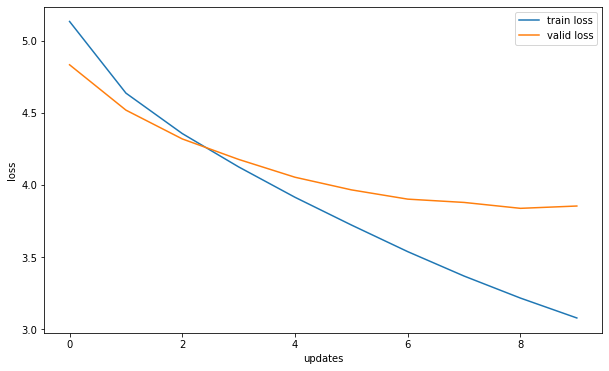

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In the following notebook we'll implement a model that achieves improved test perplexity, but only uses a single layer in the encoder and the decoder.